In [1]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from torchvision.models import efficientnet_v2_l
from test import EffnetV2_Key_Frame
import pandas as pd
import numpy as np
import torch.utils.data as data
import albumentations as A
import torchvision.transforms as transforms
from PIL import Image
import torchvision
import joblib
import cv2
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence


In [2]:
    
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from torchvision.models import efficientnet_v2_l, efficientnet_v2_s
from efficient_net_group_norm import effnetv2_m, effnetv2_l, effnetv2_xl
    
#from .cbam import CBAMBlock

class SpatialAttention(torch.nn.Module):
    def __init__(self, feature_map_size = 16, n_channels = 1280, use_layer_norm = False, use_alpha = True, use_skip_connection = True, use_gelu = False):
        super().__init__()
    
        self.use_alpha = use_alpha
        self.use_skip_connection = use_skip_connection
        self.use_gelu = use_gelu
        self.use_layer_norm = use_layer_norm
        self.n_channels = n_channels
        self.feature_map_size = feature_map_size
        self.keys = torch.nn.Conv2d(self.n_channels, self.n_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.queries = torch.nn.Conv2d(self.n_channels, self.n_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.values = torch.nn.Conv2d(self.n_channels, self.n_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.refine = torch.nn.Conv2d(self.n_channels, self.n_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.softmax = torch.nn.Softmax2d()
        self.gelu = torch.nn.GELU()
        if self.use_alpha:
            self.alpha = torch.nn.Parameter(torch.zeros(1))
        if self.use_layer_norm:
            self.layer_norm = torch.nn.LayerNorm([self.n_channels, self.feature_map_size, self.feature_map_size])
    def forward(self, x):
        
        attended_features = torch.matmul(self.softmax(torch.matmul(self.keys(x).view(x.size(0), self.n_channels, -1).permute(0, 2, 1), 
                                                                   self.queries(x).view(x.size(0), self.n_channels, -1))/self.n_channels**0.5), 
                                         self.values(x).view(x.size(0), self.n_channels, -1).permute(0, 2, 1)) # (batch_size, feature_map_size * feature_map_size, n_channels)
        attended_features = attended_features.permute(0, 2, 1).view(x.size(0), self.n_channels, self.feature_map_size, self.feature_map_size) # (batch_size, n_channels, feature_map_size, feature_map_size)
        if self.use_gelu:
            #print('spatial using gelu')
            attended_features = self.gelu(attended_features)
        attended_features = self.refine(attended_features)
        if self.use_alpha:
            #print('spatial using alpha')
            attended_features = self.alpha*attended_features + x
        else:
            #print('spatial not using alpha')
            attended_features = attended_features + x
        if self.use_layer_norm:
            #print('spatial using layer norm')
            attended_features = self.layer_norm(attended_features)
        if self.use_gelu:
            #print('spatial using gelu')
            attended_features = self.gelu(attended_features)
        return attended_features
    
    
    
class KeyFrameAttention(torch.nn.Module):
    def __init__(self, n_frames = 4, n_channels = 1280, use_alpha = False, use_layer_norm = False, use_skip_connection = False, use_gelu = False):
        super().__init__()
    
        self.use_alpha = use_alpha
        self.use_skip_connection = use_skip_connection
        self.use_gelu = use_gelu
        self.use_layer_norm = use_layer_norm
        self.n_frames = n_frames
        self.n_channels = n_channels
        self.keys = torch.nn.Linear(self.n_channels, self.n_channels, bias=False)
        self.queries = torch.nn.Linear(self.n_channels, self.n_channels, bias=False)
        self.values = torch.nn.Linear(self.n_channels, self.n_channels, bias=False)
        self.refine = torch.nn.Linear(self.n_channels, self.n_channels, bias=False)
        self.softmax = torch.nn.Softmax(dim=-1)
        if self.use_layer_norm:
            self.layer_norm = torch.nn.LayerNorm([self.n_frames, self.n_channels])
        self.gelu = torch.nn.GELU()
        if self.use_alpha and self.use_skip_connection:
            self.alpha = torch.nn.Parameter(torch.zeros(1))
        
    def forward(self, x, Mask = None):
        # x shape: 
        print('input to kfa shape', x.shape)
        keys = self.keys(x) # (batch_size, n_frames, n_channels)
        #print('keys', keys.shape)
        queries = self.queries(x) # (batch_size, n_frames, n_channels)
        #print('queries', queries)
        values = self.values(x) # (batch_size, n_frames, n_channels)
        #print('values', values)
        matmul = torch.matmul(queries, keys.permute(0, 2, 1)).float() # (batch_size, n_channels, n_frames)
        #print('matmul', matmul.shape)
        if Mask is not None:
            matmul = matmul.masked_fill(Mask == 0, -1e20)
            #print('matmul masked', matmul)
        #print('matmul shape', matmul.shape)
        softmax = self.softmax(matmul/(self.n_channels) ** 0.5) # (batch_size, n_channels, n_frames)
        attention_map = torch.matmul(values.permute(0, 2, 1), softmax) # (batch_size, n_channels, n_frames)
        #print('attention_map', attention_map.shape)
        #print('attention_map', attention_map)
        if self.use_gelu:
            #print('kfa using gelu')
            attention_map = self.gelu(attention_map)
        attended_features = self.refine(attention_map.permute(0, 2, 1)) # (batch_size, n_frames, n_channels)
        if self.use_skip_connection:
            #print('kfa using skip connection')
            if self.use_alpha:
               # print('kfa using alpha')
                attended_features = self.alpha*attended_features + x
            else:
               # print('kfa not using alpha')
                attended_features = attended_features + x
        if self.use_layer_norm:
           # print('kfa using layer norm')
            attended_features = self.layer_norm(attended_features)
        if self.use_gelu:
           # print('kfa using gelu')
            attended_features = self.gelu(attended_features)
        #print('attended_features', attended_features)
        #attended_features = attended_features + x
        #print('attended_features', attended_features)
        #attended_features = attended_features[:, :org_seq_len, :]
        #attended_features = attended_features.permute(0, 2, 1)
        #print('attended_features', attended_features)
        #print('attended_features', attended_features.shape)
        #print('attended_features', attended_features)
        return attended_features




class EffnetV2_Key_Frame(torch.nn.Module):
    def __init__(self, out_features = 7, in_channels = 1, dropout = 0.4, use_sigmoid = False, 
                 use_attention = True, use_key_frame_attention = False,
                 n_frames = 4, use_alpha = True, use_layer_norm = False, use_skip_connection = False, use_gelu = False, use_head = False):
        super().__init__()
        
        self.use_head = use_head
        self.use_alpha = use_alpha
        self.use_layer_norm = use_layer_norm
        self.use_skip_connection = use_skip_connection
        self.use_gelu = use_gelu
        self.n_frames = n_frames
        self.use_key_frame_attention = use_key_frame_attention
        self.use_sigmoid = use_sigmoid 
        self.use_attention = use_attention
        self.dropout = dropout
        self.out_features = out_features
        self.in_channels = in_channels
        self.model = efficientnet_v2_l(weights ='DEFAULT')
        self.model.features[0] = torch.nn.Conv2d(self.in_channels, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.model.avgpool = torch.nn.Identity()
        self.model.classifier = torch.nn.Sequential(nn.Dropout(self.dropout), nn.Linear(1280, self.out_features))
        self.sigmoid = torch.nn.Sigmoid()
        if self.use_head:
            self.head = torch.nn.Linear(self.n_frames, self.out_features)
        
        if self.use_attention:
           # print('Using Attention')
            self.spatial_attention = SpatialAttention(feature_map_size = 16, n_channels=1280,
                                                      use_alpha = self.use_alpha,
                                                      use_layer_norm = self.use_layer_norm,
                                                      use_skip_connection = self.use_skip_connection,
                                                      use_gelu = self.use_gelu)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        if self.use_key_frame_attention:
          #  print('Using Key Frame Attention')
            self.key_frame_attention = KeyFrameAttention(n_frames = self.n_frames, n_channels = 1280,
                                                         use_alpha = self.use_alpha,
                                                    use_layer_norm = self.use_layer_norm,
                                                      use_skip_connection = self.use_skip_connection,
                                                      use_gelu = self.use_gelu)
        
    def features_padding(self, features, max_length, split_sizes):
        padded_output = []
        #padded_output = pad_sequence(features, batch_first=True, padding_value=0)
        for i, feature in enumerate(features):
            padding_length = max_length - split_sizes[i]
            padded_seq = torch.nn.functional.pad(feature, (0, padding_length, 0, 0, 0, 0), mode='constant', value=0)
            padded_output.append(padded_seq)
        padded_output = torch.stack(padded_output)
        return padded_output
    
    def mask_sequence(self, padded_seq, org_seq_lens):  
        
        # Define the padded sequence
        padded_seq_len = padded_seq.size(-1)
        batch_len = padded_seq.size(0)
        # Define the mask tensor
        mask = torch.zeros((batch_len, padded_seq_len, padded_seq_len), dtype=torch.float32)
        
        # Set the non-padding elements to 1's
        for i in range(batch_len):
            mask[i, :, :org_seq_lens[i]] = 1
        
        
        return mask
        
    def count_params(self):
        
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
        
    
    def custom(self, module):
        def custom_forward(*inputs):
            inputs = module(inputs[0])
            return inputs
        return custom_forward
    
    def forward(self, x, org_seq_len):

        #print('shape of x', x.shape)
        x = torch.cat(x)
        features = self.model.features(x)
        #features = checkpoint_sequential(self.model.features, segments=len(self.model.features), input=x)
        if self.use_attention:
            features = self.spatial_attention(features)
        
        #print('features shape', features.shape)
        features = self.avgpool(features).squeeze(-1).permute(2, 1, 0)
        #print('features shape', features.shape)
        tensor_list = torch.split(features.permute(0, 2, 1).squeeze(0), split_size_or_sections = org_seq_len, dim=0)
        
        features_padded = self.features_padding(tensor_list, self.n_frames, org_seq_len)
        #print('features_padded shape', features_padded.shape)
        #print('features_padded shape', features_padded.shape)
        features_padded = features_padded.squeeze(1)
        #print('features_padded shape', features_padded.shape)
        mask = self.mask_sequence(features_padded, org_seq_lens = org_seq_len).cuda() if torch.cuda.is_available() else self.mask_sequence(features_padded, org_seq_lens = org_seq_len)
        #print('mask shape', mask.shape)
        
        if self.use_key_frame_attention:
          #  print('Using Key Frame Attention')
            x = self.key_frame_attention(features_padded.permute(0, 2, 1), Mask = mask)
            x = self.model.classifier(x)
        else:
          #  print('Not Using Key Frame Attention')
            #print(features_padded.shape)
            #features_padded = features_padded.mean(dim = 1)
            features_padded = features_padded.permute(0, 2, 1)
            x = self.model.classifier(features_padded)
            #print('x shape in else', x.shape)
            #print(x.shape)
        if self.use_sigmoid:
         #   print('Using Sigmoid')
            x = self.sigmoid(x)
        if self.use_head:
            x = x.permute(0, 2, 1).squeeze(1)
            x = self.head(x)
        else:
            x = x.mean(dim = 1)
        return x
    

In [3]:
def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)

In [4]:
class Video_Loader(data.Dataset):
    def __init__(self, root, videos_path, ann_path, transform=None, target_transform=None, img_scaling = False, num_frames = 4):
        
        self.num_frames = num_frames
        self.transform = transform
        self.data_path = root
        self.ann_path = ann_path
        self.videos = pd.read_csv(videos_path)
        self.data = pd.read_csv(self.ann_path)
        self.img_scaling = img_scaling
        
        
    def _load_image(self, path):
        try:
            im = Image.open(path)
            im.convert('RGB')
        except:
            print("ERROR IMG NOT LOADED: ", path)
            random_img = np.random.rand(224, 224, 3) * 255
            im = Image.fromarray(np.uint8(random_img))
        return im
    
    def __len__(self):
        return len(self.videos)
    
    
    def _load_item(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        idb = self.data.query('index == @index').iloc[0]
        
        frame_idx = idb[0]
        Class = torch.tensor(idb[1])
        video = idb[2]
        measure = torch.tensor(idb[3])
        ps = torch.tensor(idb[4])
        frames_n = torch.tensor(idb[5])
        measure_scaled = torch.tensor(idb[6], dtype=torch.float32)
        days_normalized = torch.tensor(idb[7], dtype=torch.float32)
        frame_loc = torch.tensor(idb[8], dtype=torch.float32)
        height = torch.tensor(idb[9])
        width = torch.tensor(idb[10])
        measure_normalized = torch.tensor(idb[13], dtype=torch.float32)
        images = self._load_image(self.data_path  + frame_idx + '.png')
        new_height = clamp(int(height*2.161191086437513), 0, 512)
        new_width = clamp(int(width*2.161191086437513), 0, 512)
        if self.img_scaling:
            padding = A.PadIfNeeded(min_height=512, min_width=512, border_mode=0, value=0, mask_value=0, always_apply=False, p=1.0)
            rescale = A.Resize(new_height, new_width)
            images = rescale(image = images)['image']
            images = padding(image=images)['image']
            images = np.expand_dims(images, 2)
            t = transforms.Compose([transforms.ToTensor(),])
            images = t(images)
        else:
            images = np.expand_dims(images, 2)
            t = transforms.Compose([transforms.ToTensor(),
            transforms.Resize((450, 600)),
            transforms.Pad((0, 0, 0, 150), fill = 0, padding_mode = 'constant'),
            transforms.Resize((512, 512)),
            transforms.Normalize(mean=0.1354949, std=0.18222201)])
            images = t(images)
        if self.transform is not None:
            images = self.transform(images)
        return images, Class, measure, ps, frames_n, measure_scaled, index, days_normalized, frame_loc, measure_normalized
    
    
    def __getitem__(self, index):
        video = self.videos.iloc[index].values[0]
        
        batch = self.data[self.data['video'] == video] #if len(self.data[self.data['video'] == video]) > 3 else self.data[self.data['video'] == video]
        batch_len = len(batch)
        #print('batch_len', batch_len)
        starting_position = np.random.randint(0, batch_len - self.num_frames) if batch_len > self.num_frames else 0
        #print('starting_position', starting_position)
        batch_sample = batch[starting_position:starting_position+self.num_frames] if batch_len > self.num_frames else batch
        #print('batch_sample', batch_sample)
        ids = batch_sample['index']
        images = list()
        Classes = list()
        indexes = list()
        for i in ids:
            #print(i)
            image, Class, measure, ps, frame_n, measure_scaled, index, days_normalized, frame_loc, measure_normalized = self._load_item(i)
            images.append(image)
            Classes.append(Class)
            indexes.append(index)
        images = torch.stack(images)
        Classes = torch.stack(Classes)
        assert len(images) != 0, 'images is empty'
        #print(measure)
        #print('images', images.shape)
        return images, Classes, measure, ps, frame_n, measure_scaled, indexes, days_normalized, frame_loc, measure_normalized, torch.tensor(len(images))
    


In [5]:
model = EffnetV2_Key_Frame(out_features = 1, in_channels = 1, dropout = 0.4, use_sigmoid = False, 
                 use_attention = True, use_key_frame_attention = True,
                 n_frames = 3, use_alpha = True , use_layer_norm = False, use_skip_connection = True, use_gelu = False, use_head = True)

In [6]:
checkpoint = torch.load('/data/kpusteln/Fetal-RL/src/output/effnetv2_bayes_search_bs4_lr4.0393008226517785e-05_drop0.09641683196897692_n_frames3_key_frame_attTrue_alphaTrue_use_skip_connectionTrue_use_geluFalse_use_layer_normFalse_use_headTrue/default/ckpt_epoch_400.pth', map_location=torch.device('cpu'))

In [7]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [8]:
model.eval()

EffnetV2_Key_Frame(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): S

In [10]:
class MyCollate:
    def __init__(self):
        pass
        
    def __call__(self, batch):
        images = [item[0] for item in batch]
        Classes = [item[1] for item in batch]
        measure = torch.stack([item[2] for item in batch])
        ps = torch.stack([item[3] for item in batch])
        frame_n = [item[4] for item in batch]
        measure_scaled = torch.stack([item[5] for item in batch])
        index = [item[6] for item in batch]
        days_normalized = [item[7] for item in batch]
        frame_loc = [item[8] for item in batch]
        measure_normalized = torch.stack([item[9] for item in batch])
        org_seq_lens = [item[10] for item in batch]
        images_lens = [len(img) for img in images]
        assert org_seq_lens == images_lens, 'images are not equal to org_seq_lens'
        return images, Classes, measure, ps, frame_n, measure_scaled, index, days_normalized, frame_loc, measure_normalized, org_seq_lens

In [11]:
ann_path = '/data/kpusteln/Fetal-RL/data_preparation/data_biometry/ete_model/biometry_scaled_ps/all/biometry_val_scaled_size_all.csv'
root = '/data/kpusteln/fetal/fetal_extracted/'
videos_path = '/data/kpusteln/Fetal-RL/data_preparation/data_biometry/ete_model/biometry_scaled_ps/all/videos_val.csv'

In [12]:
dataset = Video_Loader(root = root, videos_path = videos_path, ann_path = ann_path, 
                                   transform = None, img_scaling = False, num_frames = 3)

In [13]:
collater = MyCollate()

In [14]:
data_loader_val = torch.utils.data.DataLoader(
    dataset, 
    shuffle = True,
    batch_size=1,
    num_workers=8,
    drop_last=True,
    collate_fn = collater)

In [15]:
for i in data_loader_val:
    img_org = i[0]
    measure = i[2]
    org_seq_lens = i[10]
    ps = i[3]
    break

In [ ]:
with torch.no_grad():
    img = torch.cat(img_org)
    print(img.shape)
    features = model.model.features(img)
    #features = checkpoint_sequential(self.model.features, segments=len(self.model.features), input=x)
    features = model.spatial_attention(features)

    #print('features shape', features.shape)
    features = model.avgpool(features).squeeze(-1)
    print('features shape', features.shape)
    tensor_list = torch.split(features.squeeze(-1), split_size_or_sections = org_seq_lens, dim=0)
    features_padded = pad_sequence(tensor_list, batch_first=True, padding_value=0)
    features_padded = features_padded.squeeze(1).permute(0, 2, 1)
    #print('features_padded shape', features_padded.shape)
    mask = model.mask_sequence(features_padded, org_seq_lens = org_seq_lens)
    kfa = model.key_frame_attention(features_padded, Mask = mask)
    cls_out = model.model.classifier(kfa)
    features_classifier = cls_out.permute(0, 2, 1).squeeze(1)
    print(features_classifier.shape)
    x = model.head(features_classifier)

In [553]:
tensor_list = torch.split(features.squeeze(-1), split_size_or_sections = org_seq_lens, dim=0)

In [555]:
padded_output = pad_sequence(tensor_list, batch_first=True, padding_value=0)

In [558]:
padded_output[8]

tensor([[-0.0524, -0.0098, -0.0207,  ...,  0.0476, -0.0637, -0.0294],
        [-0.0489, -0.0087, -0.0220,  ...,  0.0459, -0.0662, -0.0241],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [520]:
tensor_list[0].shape

torch.Size([1, 1280, 3])

In [ ]:
scaler = joblib.load('/data/kpusteln/Fetal-RL/data_preparation/data_biometry/ete_model/biometry_scaled_ps/all/all_scaler')

In [ ]:
ps = ps.unsqueeze(1)

In [ ]:
ps.shape

torch.Size([16, 1])

In [ ]:
predicted_measure = scaler.inverse_transform(x.cpu().numpy()) * ps.numpy()

In [16]:
image = img_org[0][0]

In [ ]:
class AdjustContrast(object):
    def __init__(self, contrast_factor):
        self.contrast_factor = contrast_factor

    def __call__(self, img):
        return torchvision.transforms.functional.adjust_contrast(img, self.contrast_factor)

In [26]:
image

tensor([[[-0.7436, -0.7436, -0.7436,  ..., -0.7436, -0.7436, -0.7436],
         [-0.7436, -0.7436, -0.7436,  ..., -0.7436, -0.7436, -0.7436],
         [-0.7436, -0.7436, -0.7436,  ..., -0.7436, -0.7436, -0.7436],
         ...,
         [-0.7436, -0.7436, -0.7436,  ..., -0.7436, -0.7436, -0.7436],
         [-0.7436, -0.7436, -0.7436,  ..., -0.7436, -0.7436, -0.7436],
         [-0.7436, -0.7436, -0.7436,  ..., -0.7436, -0.7436, -0.7436]]])

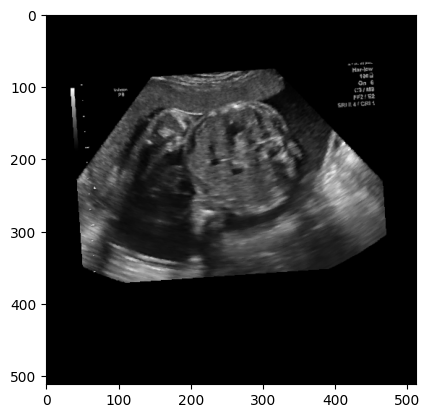

In [38]:
t = transforms.Compose([transforms.RandomAffine(degrees=5, scale = (0.5, 1), fill = -0.7436),])
image_adjusted = t(image)
plt.imshow(image_adjusted.squeeze(0), cmap = 'gray')

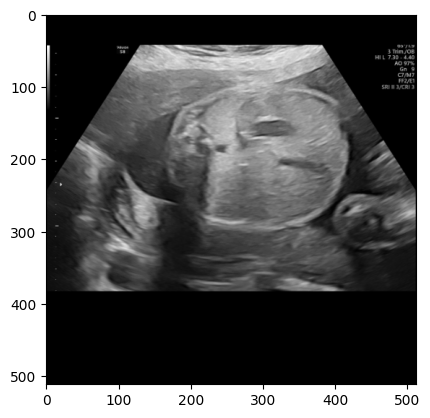

In [149]:
plt.imshow(image.squeeze(0), cmap = 'gray')

In [150]:
image_contrasted = torchvision.transforms.functional.autocontrast(image).squeeze(0)

In [151]:
image_contrasted


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

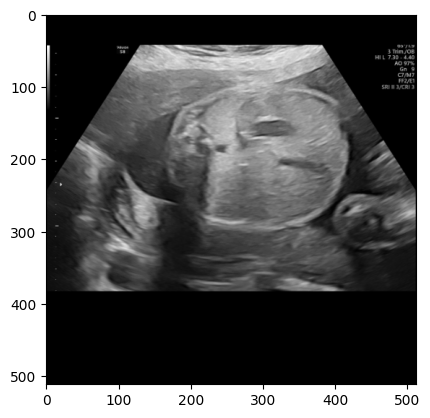

In [152]:
plt.imshow(image_contrasted, cmap = 'gray')

In [22]:
img_ctr = torchvision.transforms.functional.adjust_contrast(img, 1.2)

TypeError: img should be PIL Image. Got <class 'numpy.ndarray'>

In [22]:
plt.imshow(img_ctr.squeeze(0), cmap='gray')

NameError: name 'plt' is not defined

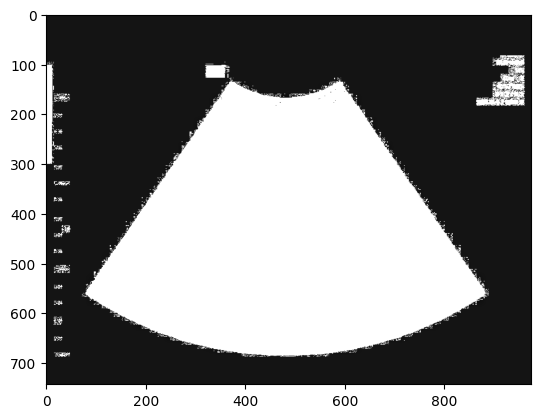

In [29]:
import cv2

# Load the ultrasound image

# Perform despeckling using a median filter
clahe = cv2.createCLAHE(clipLimit = 20, tileGridSize=(32,32))

# Apply CLAHE to the image
gray_img = np.array(img * 255, dtype=np.uint16)
gray_16bit_img = cv2.convertScaleAbs(gray_img, alpha=(65535.0/255.0))
img_clahe = clahe.apply(gray_16bit_img)
plt.imshow(img_clahe, cmap='gray')

In [52]:
gray_img = np.array(i[0][0][0].squeeze(0).numpy() * 255, dtype=np.uint8)

In [55]:
gray_16bit_img = cv2.convertScaleAbs(gray_img, alpha=(65535.0/255.0))
img_clahe = clahe.apply(gray_16bit_img)

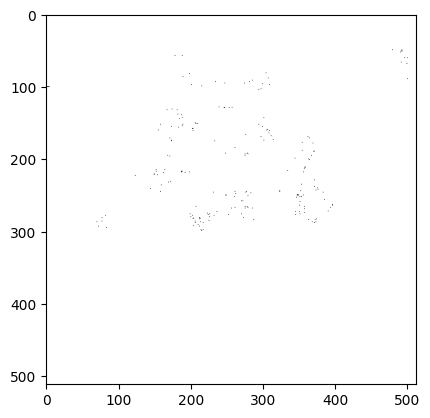

In [56]:
plt.imshow(img_clahe, cmap='gray')

In [135]:
data_train = pd.read_csv('/data/kpusteln/Fetal-RL/data_preparation/data_biometry/ete_model/biometry_scaled_ps/class_data/biometry_train_all.csv')
data_val = pd.read_csv('/data/kpusteln/Fetal-RL/data_preparation/data_biometry/ete_model/biometry_scaled_ps/class_data/biometry_val_all.csv')

In [136]:
data_head_train = data_train[(data_train['Class'] == 1) | (data_train['Class'] == 2)]
data_abdomen_train = data_train[(data_train['Class'] == 3) | (data_train['Class'] == 4)]
data_femur_train = data_train[(data_train['Class'] == 5) | (data_train['Class'] == 6)]

# val
data_head_val = data_val[(data_val['Class'] == 1) | (data_val['Class'] == 2)]
data_abdomen_val = data_val[(data_val['Class'] == 3) | (data_val['Class'] == 4)]
data_femur_val = data_val[(data_val['Class'] == 5) | (data_val['Class'] == 6)]


In [137]:
data_head_train.to_csv('/data/kpusteln/Fetal-RL/data_preparation/data_biometry/ete_model/biometry_scaled_ps/class_data_split/train_head.csv', index=False)
data_abdomen_train.to_csv('/data/kpusteln/Fetal-RL/data_preparation/data_biometry/ete_model/biometry_scaled_ps/class_data_split/train_abdomen.csv', index=False)
data_femur_train.to_csv('/data/kpusteln/Fetal-RL/data_preparation/data_biometry/ete_model/biometry_scaled_ps/class_data_split/train_femur.csv', index=False)

# val

data_head_val.to_csv('/data/kpusteln/Fetal-RL/data_preparation/data_biometry/ete_model/biometry_scaled_ps/class_data_split/val_head.csv', index=False)
data_abdomen_val.to_csv('/data/kpusteln/Fetal-RL/data_preparation/data_biometry/ete_model/biometry_scaled_ps/class_data_split/val_abdomen.csv', index=False)
data_femur_val.to_csv('/data/kpusteln/Fetal-RL/data_preparation/data_biometry/ete_model/biometry_scaled_ps/class_data_split/val_femur.csv', index=False)

In [128]:
data_head_train['Class'].value_counts()
head_class_weight = torch.FloatTensor([1, 6.44])
torch.save(head_class_weight, '/data/kpusteln/Fetal-RL/data_preparation/data_biometry/ete_model/biometry_scaled_ps/class_data_split/head_class_weight.pt')

In [131]:
femur_class_weight = torch.FloatTensor([1, 1.3])
torch.save(femur_class_weight, '/data/kpusteln/Fetal-RL/data_preparation/data_biometry/ete_model/biometry_scaled_ps/class_data_split/femur_class_weight.pt')

In [134]:
abdomen_class_weight = torch.FloatTensor([1, 21.24])
torch.save(abdomen_class_weight, '/data/kpusteln/Fetal-RL/data_preparation/data_biometry/ete_model/biometry_scaled_ps/class_data_split/abdomen_class_weight.pt')